In [2]:
print('hello')

hello


In [ ]:
from pathlib import Path
from typing import Any, Dict
import yaml

def load_yaml(p: Path) -> Dict[str, Any]:
    """
    Opens a file.yaml content and load it into a variable as a dictionary
    """
    with p.open("r", encoding="utf-8") as f:
        return yaml.safe_load(f)
    
load_yaml(p=Path(".\components\prep.yaml")) 

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
C:\Users\joule\AppData\Local\Temp\ipykernel_24440\3791711231.py:12: SyntaxWarning: invalid escape sequence '\c'
  load_yaml(p=Path(".\components\prep.yaml"))


{'$schema': 'local.commandComponent',
 'name': 'prepare_iris',
 'display_name': 'PrepIris',
 'version': 1,
 'type': 'command',
 'inputs': {'input_data': {'type': 'uri_folder'}},
 'outputs': {'prep_data': {'type': 'uri_folder'}},
 'code': '../prep_src',
 'environment': 'local/python',
 'command': 'python prep.py --input_data ${{inputs.raw_data}}  --prep_data ${{outputs.prep_data}}'}

In [16]:
from sklearn.datasets import load_iris

data = load_iris(as_frame=True)
df = data.frame  # <--- déjà un DataFrame avec data+target
df.to_csv("../../data/iris.csv", index=False)

In [ ]:
# import required libraries
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

from azure.ai.ml import MLClient, Input
from azure.ai.ml.dsl import pipeline
from azure.ai.ml import load_component

parent_dir = ""

# load_component(source: PathLike | str | IO | None = None, *, relative_origin: str | None = None, params_override: List[Dict] | None = None, **kwargs: Any) -> CommandComponent | ParallelComponent | PipelineComponent

# 1. Load components
prepare_data = load_component(source=parent_dir + "./prep.yml")

# 2. Construct pipeline
@pipeline()
def nyc_taxi_data_regression(pipeline_job_input):
    """NYC taxi data regression example."""
    prepare_sample_data = prepare_data(raw_data=pipeline_job_input)
    
    return {
        "pipeline_job_prepped_data": prepare_sample_data.outputs.prep_data
    }


pipeline_job = nyc_taxi_data_regression(
    Input(type="uri_folder", path=parent_dir + "./data/")
)

In [2]:
import pandas as pd
import json, numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

RANDOM_STATE = 42


def make_folds(trainval_csv: Path, folds_dir: Path, k: int = 5):
    df = pd.read_csv(trainval_csv)
    y = df["target"].to_numpy()
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    folds_dir.mkdir(parents=True, exist_ok=True)
    for i, (tr, va) in enumerate(skf.split(np.zeros(len(y)), y)):
        with (folds_dir / f"fold_{i}.json").open("w") as f:
            json.dump({"train_idx": tr.tolist(), "val_idx": va.tolist()}, f, indent=2)

make_folds(trainval_csv=Path("data/iris.csv"), folds_dir=Path("temp"))


In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X, y = make_hastie_10_2(n_samples=8000, random_state=42)

# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={"min_samples_split": range(2, 403, 20)},
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)
gs.fit(X, y)
results = gs.cv_results_

In [2]:
results

{'mean_fit_time': array([0.11825614, 0.11227775, 0.11453767, 0.10902567, 0.10527153,
        0.10436878, 0.09887753, 0.09993143, 0.10279784, 0.09774699,
        0.09463615, 0.09435163, 0.09491162, 0.09370332, 0.09446521,
        0.09462166, 0.09400454, 0.08914051, 0.09165235, 0.09061947,
        0.0918581 ]),
 'std_fit_time': array([0.00735501, 0.00270986, 0.00729024, 0.00181413, 0.00371456,
        0.00372465, 0.00254557, 0.00620776, 0.00992656, 0.00711121,
        0.00322612, 0.00184361, 0.00244007, 0.00699481, 0.0040008 ,
        0.00697805, 0.00775302, 0.00330613, 0.00363744, 0.00203461,
        0.00751039]),
 'mean_score_time': array([0.0029171 , 0.00233479, 0.00274606, 0.00219564, 0.0031188 ,
        0.00282898, 0.00221705, 0.0021069 , 0.00206895, 0.00213227,
        0.00238662, 0.00190663, 0.00209255, 0.0023035 , 0.00260544,
        0.00230222, 0.00190468, 0.00224009, 0.002033  , 0.00200205,
        0.00252991]),
 'std_score_time': array([6.50071967e-04, 1.15437644e-03, 6.252293

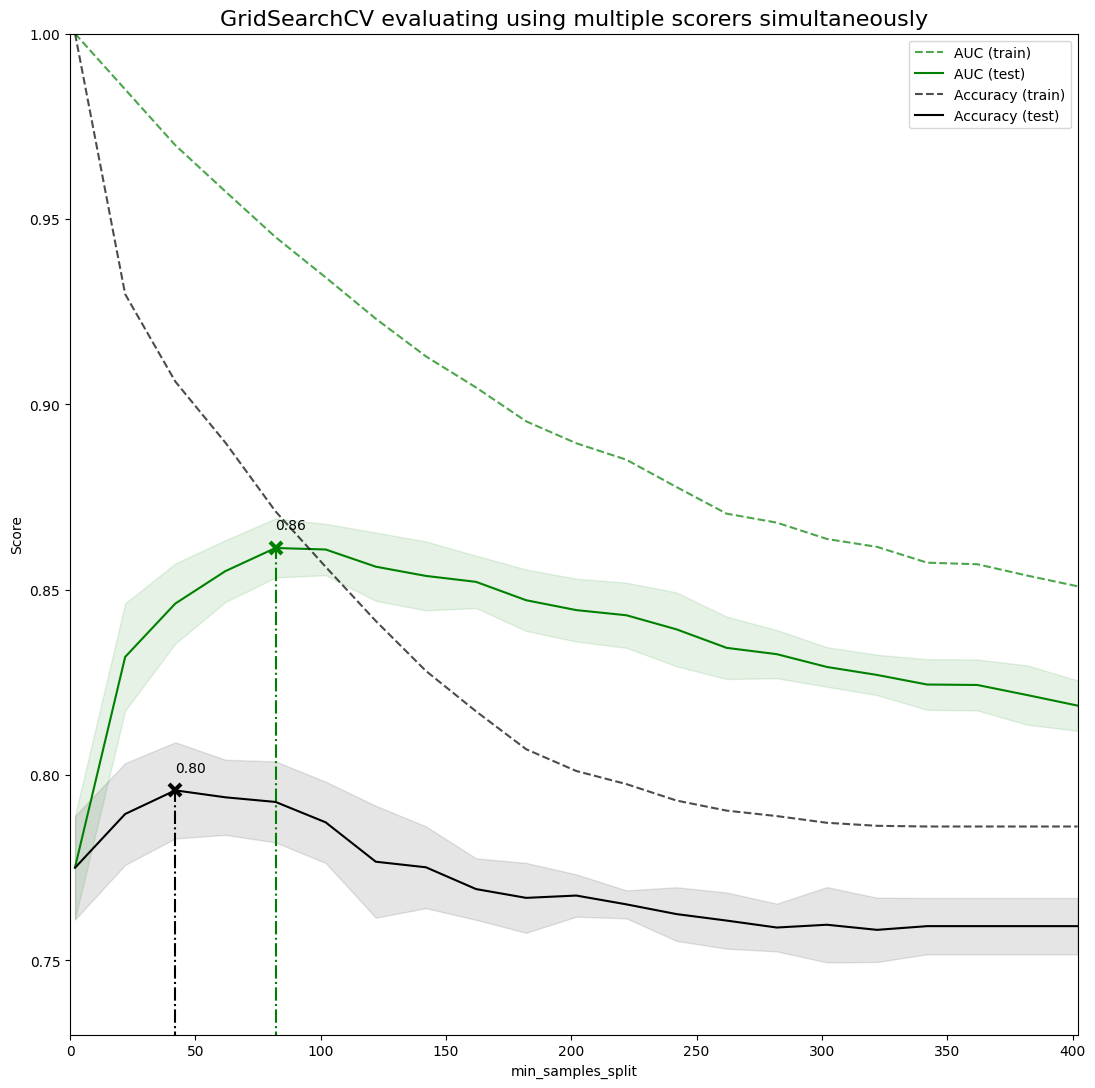

In [3]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_min_samples_split"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

Average difference of 0.007581 with std. dev. of 0.007833.


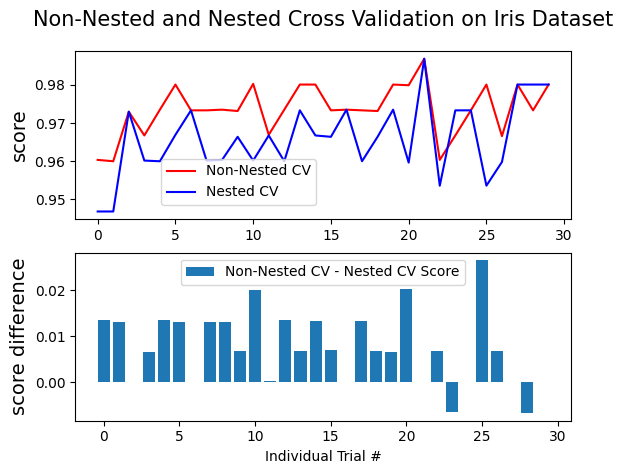

In [4]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()